In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [2]:
def Convert_to_PGM_and_Split_Train_Test(root, split_ratio):
    
    import os
    import random
    import shutil
    from PIL import Image

    # Set up paths
    source_dir = os.path.join(root, "all_data")
    train_dir = os.path.join(root, "train")
    test_dir = os.path.join(root, "test")

    # remove train and test directories if already they exist
    if os.path.exists(train_dir):
        shutil.rmtree(train_dir)
    if os.path.exists(test_dir):
        shutil.rmtree(test_dir)
        
    # create fresh train and test directories
    os.makedirs(train_dir)
    os.makedirs(test_dir)

    # Set up train and test subdirectories
    for sub_dir in ['accident', 'no_accident', 'not_related']:
        os.makedirs(os.path.join(train_dir, sub_dir), exist_ok=True)
        os.makedirs(os.path.join(test_dir, sub_dir), exist_ok=True)
    
    # splitting the data and copying as .pgm
    for sub_dir in ['accident', 'no_accident', 'not_related']:
        images = os.listdir(os.path.join(source_dir, sub_dir))
        num_images = len(images)
        num_train = int(num_images * split_ratio)
        train_images = random.sample(images, num_train)
        for image in images:
            source_path = os.path.join(source_dir, sub_dir, image)
            if image in train_images:
                dest_path = os.path.join(train_dir, sub_dir, os.path.splitext(image)[0] + '.pgm')
            else:
                dest_path = os.path.join(test_dir, sub_dir, os.path.splitext(image)[0] + '.pgm')
            with Image.open(source_path) as img:
                img = img.convert('L')
                img.save(dest_path)

In [3]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            img1_tuple = random.choice(self.imageFolderDataset.imgs)

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [53]:
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(         
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2), 
        )
       
        # fully connected layer, output 2 classes
        self.fc1 = nn.Linear(2*28*28, 2)
       
        
    def forward_once(self, x):
        # This function will be called for both images
        # Its output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [42]:
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [43]:
# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()
    
# visualizing one batch of data    
def visualize_one_batch(siamese_dataset, batch_size):
    
    # Create a simple dataloader just for simple visualization
    vis_dataloader = DataLoader(siamese_dataset,
                            shuffle=True,
                            batch_size=8)

    # Extract one batch
    example_batch = next(iter(vis_dataloader))

    # Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
    # If the label is 1, it means that it is not the same person, label is 0, same person in both images
    concatenated = torch.cat((example_batch[0], example_batch[1]),0)

    imshow(torchvision.utils.make_grid(concatenated))
    print(example_batch[2].numpy().reshape(-1))
    print("\n0: same class\n1: different class")

In [36]:
#splitting the data into train and test

# Convert_to_PGM_and_Split_Train_Test(root="dataset", split_ratio=0.8)

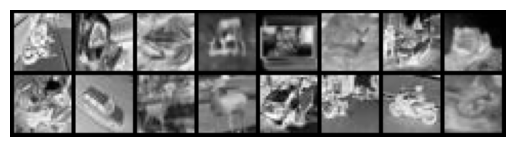

[0. 1. 1. 0. 1. 1. 0. 0.]

0: same class
1: different class


In [55]:
# Load the training dataset
train_data_folder = datasets.ImageFolder(root="dataset/train")

# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((28, 28)),
                                     transforms.ToTensor()
                                    ])

siamese_train_dataset = SiameseNetworkDataset(imageFolderDataset=train_data_folder,
                                        transform=transformation)

visualize_one_batch(siamese_train_dataset, batch_size=8)

Epoch  0 ::  loss = 0.9368717161487771

Epoch  1 ::  loss = 0.9334312952272424

Epoch  2 ::  loss = 0.9275273092805523

Epoch  3 ::  loss = 0.9294757448374953

Epoch  4 ::  loss = 0.9253330557313684

Epoch  5 ::  loss = 0.9282163778940836

Epoch  6 ::  loss = 0.9271480324061494

Epoch  7 ::  loss = 0.9293087473198703

Epoch  8 ::  loss = 0.9258777989100103

Epoch  9 ::  loss = 0.9226650100320442



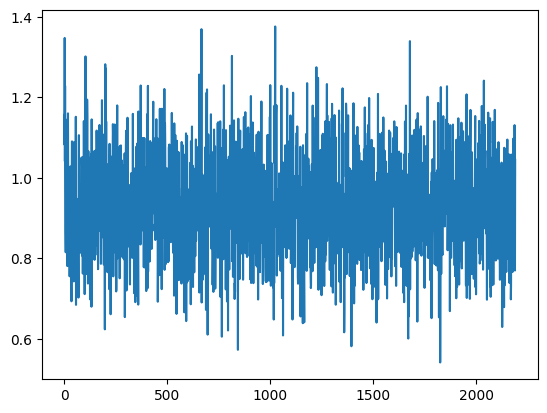

In [59]:
# Load the training dataset
train_dataloader = DataLoader(siamese_train_dataset,
                        shuffle=True,
                        batch_size=64)

model = SiameseNetwork()
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0005)

counter = []
loss_history = [] 
tot_iteration= 0

# Iterate throught the epochs
for epoch in range(10):

    tot_loss = 0
    
    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = model(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        tot_iteration += 1

        counter.append(tot_iteration)
        loss_history.append(loss_contrastive.item())
        
        tot_loss += loss_contrastive.item()
    
    tot_loss /= len(train_dataloader)
    
    print(f"Epoch  {epoch} ::  loss = {tot_loss}\n")

    
show_plot(counter, loss_history)